In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

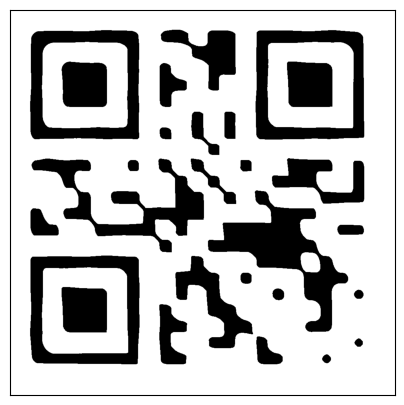

In [35]:
def sharpen_img(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    return cv2.filter2D(image, -1, kernel)

def add_quiet_zone(image, border_size=10):

    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=[255, 255, 255])

img = cv2.imread("09-My-phone-fell-while-taking-this-one-...-or-did-it.png", cv2.IMREAD_GRAYSCALE)
#img = 255 - img
_, img_thresh = cv2.threshold(img, 53, 255, cv2.THRESH_BINARY)
img_sharpened = sharpen_img(img_thresh)
edges = cv2.Canny(img_sharpened, 100, 200)
img_combined = cv2.bitwise_or(img_sharpened, edges)
img_final = add_quiet_zone(img_combined, 20)

fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img_final, cmap='gray');

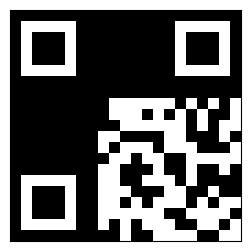

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = "09-My-phone-fell-while-taking-this-one-...-or-did-it.png"  # Assuming the first image is saved at this path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Assume the grid is already defined correctly in img_21x21_grid; if not, resize it as shown previously
img_21x21_grid = cv2.resize(img, (21, 21), interpolation=cv2.INTER_NEAREST) // 255

# Define QR-like features in a 21x21 grid
def apply_qr_features(grid):
    # Function to draw the position detection patterns
    def draw_position_detection(grid, top_left_row, top_left_col):
        grid[top_left_row:top_left_row+7, top_left_col:top_left_col+7] = 0  # Large black square
        grid[top_left_row+1:top_left_row+6, top_left_col+1:top_left_col+6] = 1  # Inner white square
        grid[top_left_row+2:top_left_row+5, top_left_col+2:top_left_col+5] = 0  # Innermost black square
    
    # Draw the position detection patterns
    draw_position_detection(grid, 0, 0)
    draw_position_detection(grid, 0, 14)
    draw_position_detection(grid, 14, 0)

    # Add a basic alignment pattern
    grid[17:20, 17:20] = 0
    grid[18, 18] = 1

    # Add some random data for visualization
    for i in range(8, 21):
        for j in range(8, 21):
            grid[i, j] = np.random.choice([0, 1])

    return grid

# Apply QR-like features
img_21x21_grid = apply_qr_features(img_21x21_grid.astype(np.uint8))

# Display the result
plt.figure(figsize=(3, 3))
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(img_21x21_grid, cmap='gray')
plt.show()


In [37]:
# Dictionary of all masks and their equivalent formulae
# P.S. I modified them to account for that I skipped the FEC mask part above
# If you will do it, do not XOR the mask if you wish to use this MASKS table
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}
# Enum for the different directions of reading blocks in the QR code
# The number indicates how many bytes are in this block
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [38]:
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [39]:
img_21x21_grid_inv = 1 - img_21x21_grid
ecl = img_21x21_grid_inv[8, 0:2]

mask = img_21x21_grid_inv[8, 2:5]

enc_bits = apply_mask_general(21-1, 21-1, img_21x21_grid_inv, mask, UP4)

len_bits = apply_mask_general(21-3, 21-1, img_21x21_grid_inv, mask, UP8)

len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [1 1]
MASK = [1 1 1]
ENC = [0, 0, 0, 1]
LEN = [1, 0, 0, 0, 1, 1, 1, 1] = 143 data symbols, each consisting of 8 bits


In [40]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [45]:
if len_int > len(block_starting_indices):
    print("Warning: More data symbols are expected than there are blocks defined. Check your QR code parameters.")
    len_int = len(block_starting_indices)  # Adjust len_int to prevent out-of-bounds error


message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)

byte_index = 0
while byte_index < len(block_starting_indices) and byte_index < len_int:
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

# After finishing all characters, handle the next 4 bits as the '0000' terminator
if byte_index < len(block_starting_indices):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
    byte_index += 1

# Reading remaining bytes
while byte_index < len(block_starting_indices) and byte_index < 25 - len_int:
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1


start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1
# Let's see what the bytes that follow look like
# There supposedly remain 25-len-1 bytes to be read
for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

10000110 (=134) = 
00010000 (=016) = 
01011001 (=089) = Y
01110010 (=114) = r
10010110 (=150) = 
00111100 (=060) = <
00000111 (=007) = 
11111000 (=248) = ø
01011010 (=090) = Z
00010010 (=018) = 
00000111 (=007) = 
10000111 (=135) = 
01111001 (=121) = y
10001001 (=137) = 
01010101 (=085) = U
01011010 (=090) = Z
10101010 (=170) = ª
1001 (=009) = 	
01001100 (=076) = L
01111101 (=125) = }
11010000 (=208) = Ð
01011111 (=095) = _
11111111 (=255) = ÿ
01010101 (=085) = U
10101010 (=170) = ª


IndexError: list index out of range